In [1]:
import simplejson as json

with open('0001_bytearray_master.json') as f:
    byte_array_data = json.load(f)

with open('0002_binary_master.json') as f:
    bin_obj_data = json.load(f)

In [5]:
from collections import defaultdict


def prepare_data(data, name_pattern='', max_threshold=102400, min_threshold=0):
    ret = {'simple': defaultdict(dict), 'partition_aware': defaultdict(dict)}

    for bench in data['benchmarks']:
        params = bench['param'].split('-')
        name = bench['name']
        if name_pattern not in name:
            continue
        
        batch_sz = int(params[2]) if len(params) == 3 else 0
        value_sz = int(params[1])

        if not (min_threshold < value_sz < max_threshold):
            continue
        
        if 'async' in name:
            continue
        
        median = bench['stats']['median'] * 1000000
        ret[params[0]][value_sz] = median
    return ret

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


def plot(pa_data, simple_data, title='',yscale='linear', time_scale=1, ylabel='us'):
    labels = []
    for k in pa_data.keys():
        if k // (1024 * 1024) > 0 or k == 1024 * 1024:
            labels.append(f'{k / (1024 * 1024)}Mb')
        elif k // 1024 > 0:
            labels.append(f'{k / 1024}Kb')
        else:
            labels.append(k)

    
    pa_means = [v / time_scale for v in pa_data.values()]
    simple_means = [v / time_scale for v in simple_data.values()]
    

    x = np.arange(len(labels))
    width = 0.3

    fig, ax = plt.subplots()
    plt.rcParams["figure.figsize"] = (15, 12)
    plt.yscale(yscale)
    
    rects = []
   
    rects.append(ax.bar(x - width * 0.5, simple_means, width, label='simple'))
    rects.append(ax.bar(x + width * 0.5, pa_means, width, label='partition_aware'))

    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    for rect in rects:
        ax.bar_label(rect, padding=3)


    fig.tight_layout()

    plt.show()

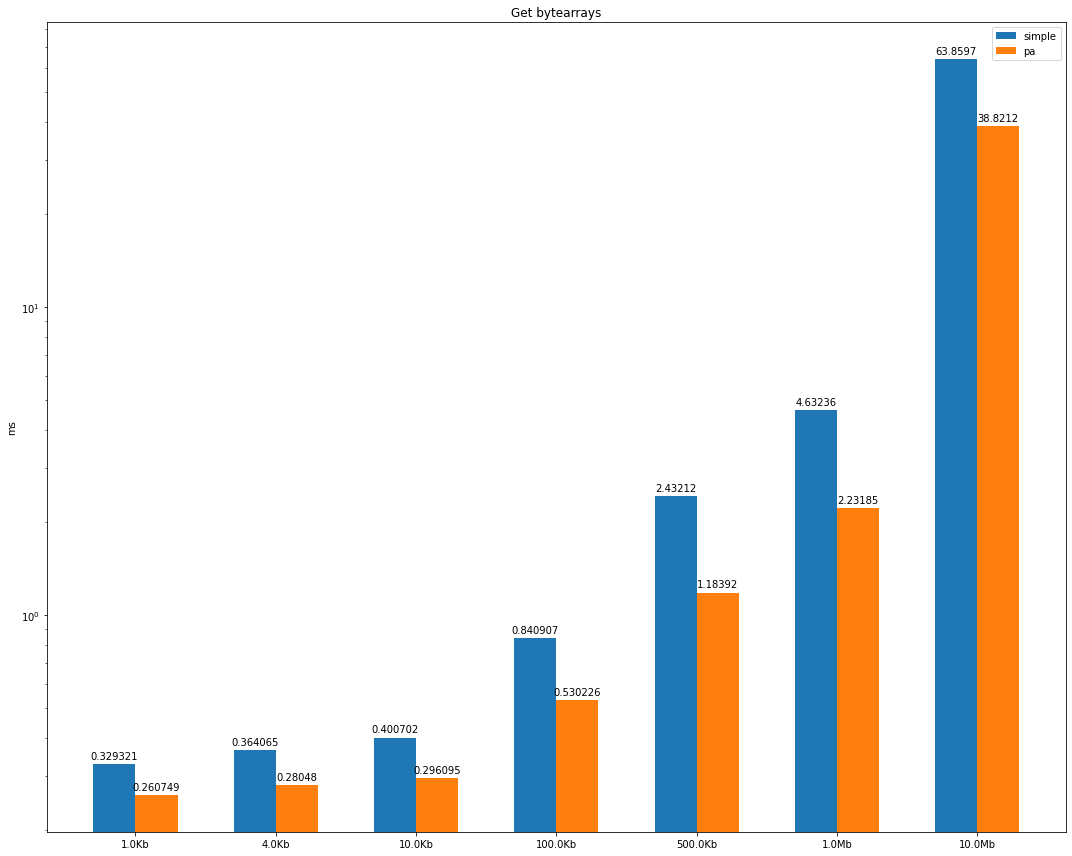

In [8]:
get_data = prepare_data(byte_array_data, 'get', max_threshold=20 * 1024 * 1024)

plot(get_data['partition_aware'], get_data['simple'], 'Get bytearrays', yscale='log', ylabel='ms', time_scale=1000)

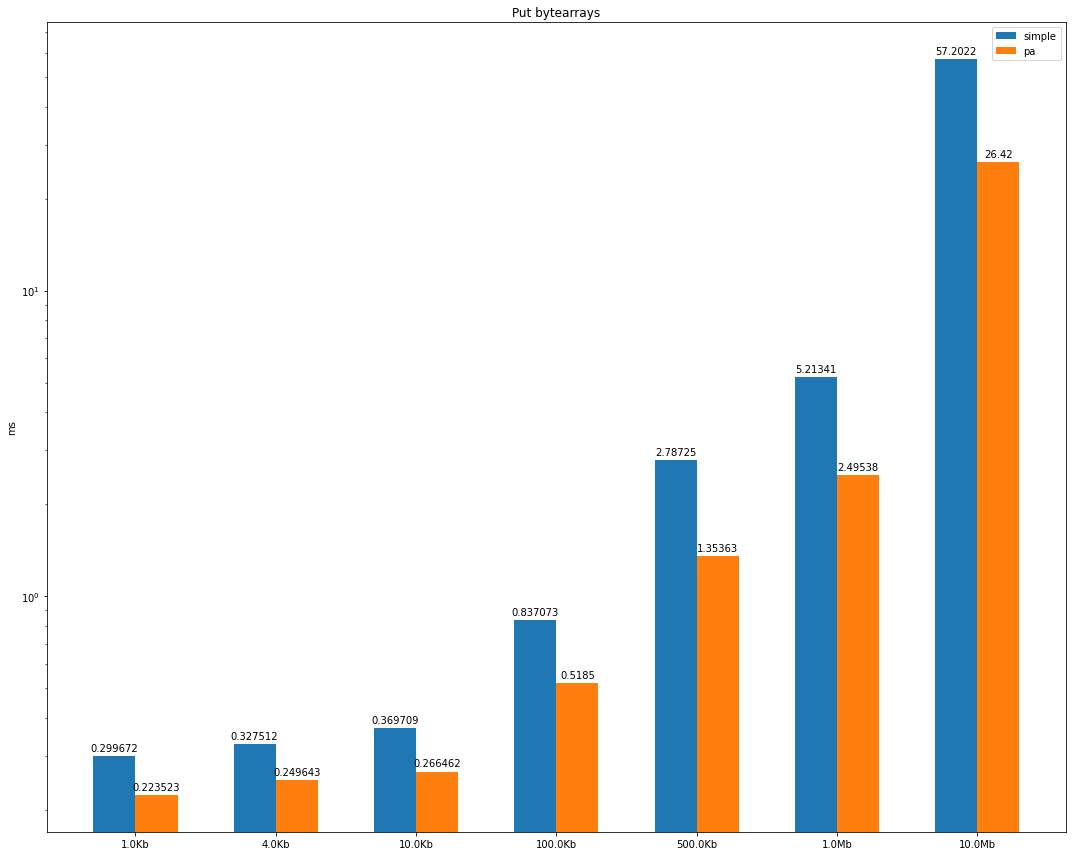

In [12]:
put_data = prepare_data(byte_array_data, 'put', max_threshold=20 * 1024 * 1024)

plot(put_data['partition_aware'], put_data['simple'], 'Put bytearrays', yscale='log', ylabel='ms', time_scale=1000)

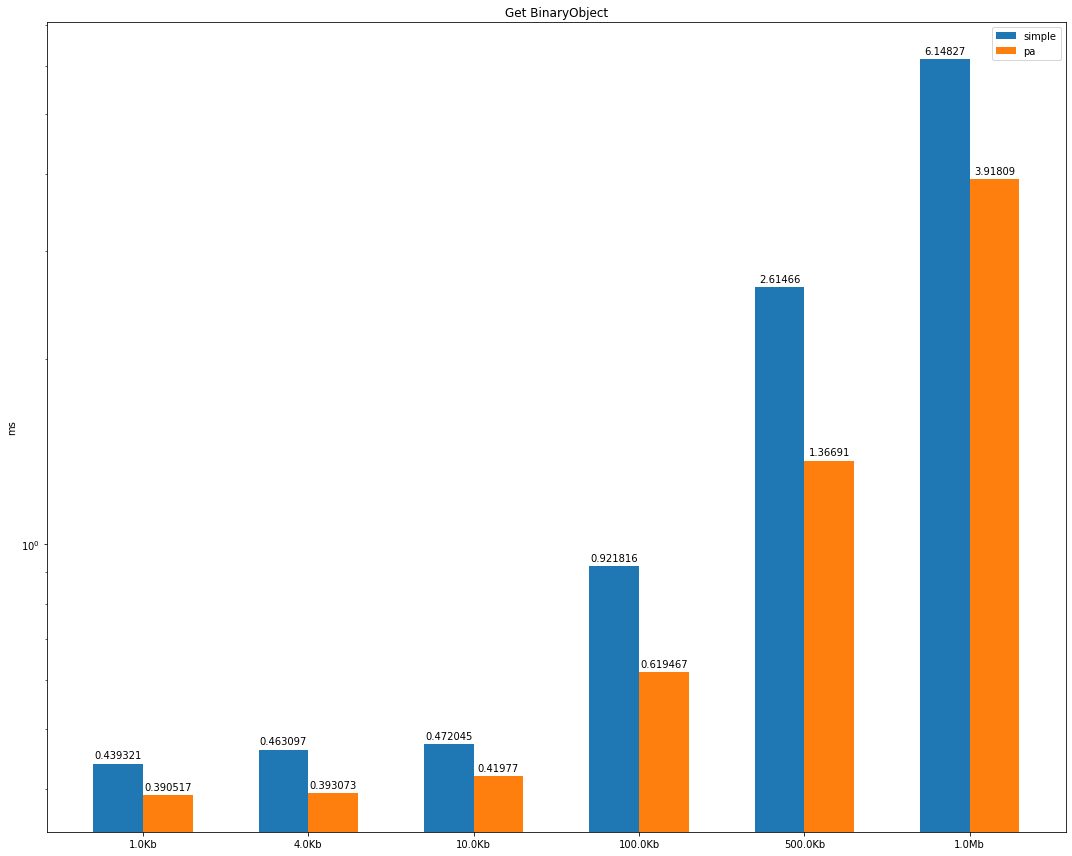

In [13]:
get_data = prepare_data(bin_obj_data, 'get', max_threshold=20 * 1024 * 1024)

plot(get_data['partition_aware'], get_data['simple'], 'Get BinaryObject', yscale='log', ylabel='ms', time_scale=1000)

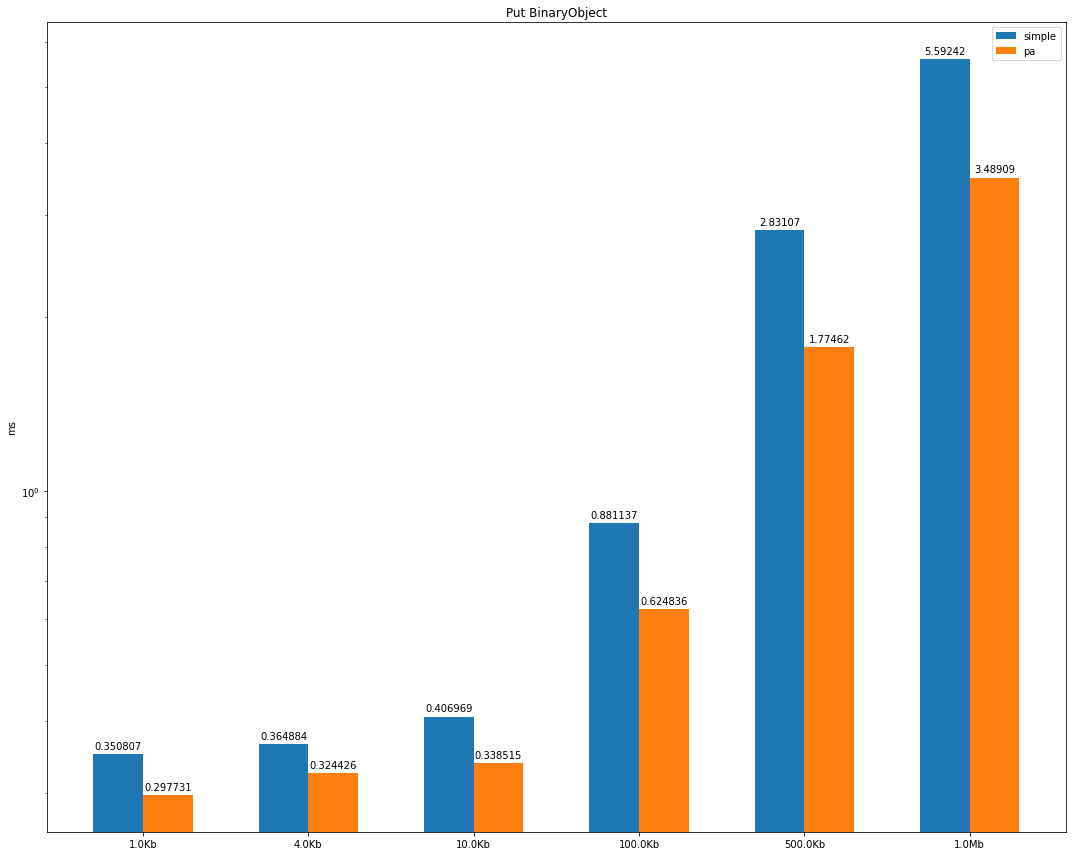

In [14]:
put_data = prepare_data(bin_obj_data, 'put', max_threshold=20 * 1024 * 1024)

plot(put_data['partition_aware'], put_data['simple'], 'Put BinaryObject', yscale='log', ylabel='ms', time_scale=1000)